## Dependencies and imports

In [1]:
#!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
#!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [2]:
#!pip install pycocotools

In [3]:
import sys
sys.path.insert(0, "../../../efficientdet-pytorch")
sys.path.insert(0, "../../../omegaconf")
sys.path.insert(0, "../")

In [4]:
import torch
import torch.nn as nn
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchEval
from effdet.efficientdet import HeadNet

from metrics import eval_metrics

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [5]:
DATA_DIR = '/relevance2-nfs/chec/data/wheat'

In [6]:
marking = pd.read_csv(f'{DATA_DIR}/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

About data splitting you can read [here](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble):

In [7]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/relevance2-nfs/chec/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [8]:
df_folds.reset_index().head()

image_id  bbox_count     source stratify_group  fold
0  00333207f          55  arvalis_1    arvalis_1_3     3
1  005b0d8bb          20    usask_1      usask_1_1     7
2  006a994f7          25    inrae_1      inrae_1_1     2
3  00764ad5d          41    inrae_1      inrae_1_2     0
4  00b5fefed          25  arvalis_3    arvalis_3_1     6

In [9]:
df_folds['source'].value_counts()

arvalis_1    1055
ethz_1        747
arvalis_3     559
rres_1        432
arvalis_2     204
usask_1       200
inrae_1       176
Name: source, dtype: int64

In [10]:
df_folds.shape

(3373, 4)

In [11]:
image_files = os.listdir(os.path.join(DATA_DIR, 'train'))
all_img_ids = [x.split('.')[0] for x in image_files]
no_box_images = list(set(all_img_ids) - set(marking.image_id.unique()))

In [12]:
def get_fold_img_ids(ifold):
    val_sources = {
        0: 'arvalis_2',
        1: 'usask_1',
        2: 'rres_1',
        3: 'arvalis_3',
        4: 'inrae_1'
    }
    val_ids = df_folds.loc[(df_folds['fold']==ifold) | (df_folds['source']==val_sources[ifold])].index.values.tolist()
    #print(len(val_ids))
    train_ids = list(set(df_folds.index.values) - set(val_ids))
    #print(len(train_ids))
    return np.array(train_ids), np.array(val_ids)

In [13]:
marking.head()

image_id  width  height   source      x      y      w      h
0  b6ab77fd7   1024    1024  usask_1  834.0  222.0   56.0   36.0
1  b6ab77fd7   1024    1024  usask_1  226.0  548.0  130.0   58.0
2  b6ab77fd7   1024    1024  usask_1  377.0  504.0   74.0  160.0
3  b6ab77fd7   1024    1024  usask_1  834.0   95.0  109.0  107.0
4  b6ab77fd7   1024    1024  usask_1   26.0  144.0  124.0  117.0

## Albumentations

In [14]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                #A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.Blur(blur_limit=3, p=0.2),
            A.ToGray(p=0.1),
            #A.GaussianBlur(p=1),
            #A.RGBShift(p=1),
            #A.RandomSnow(p=1),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

## Dataset

In [15]:
TRAIN_ROOT_PATH = f'{DATA_DIR}/train'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test
        self.yxyx = True
        self.img_size = 1024

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test:
            image, boxes = self.load_image_and_boxes(index)
            if boxes is None:
                boxes = np.array([[0., 0., 1., 1.]])
                labels = torch.tensor([2.]).long()
            # there is only one class
            else:
                labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        else:
            r = random.random()
            if r < 0.1:
                image, boxes = self.load_image_and_boxes(index)
            elif r < 0.2:
                #print('mixup1')
                image, boxes = self.mixup1(index)
            elif r < 0.6:
                #print('mixup3')
                image, boxes = self.mixup3(index)
            else:
                #print('cutmix')
                image, boxes = self.load_cutmix_image_and_boxes(index)

            # there is only one class
            labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        if len(records) < 1:
            return image, None
        #print(records)
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        #print('>>>boxes:', boxes)
        #print('image shape:', image.shape)
        return image, boxes
    
    def mixup1(self, index):
        img, boxes = self.load_image_and_boxes(index)
        rindex = random.randint(0, self.image_ids.shape[0] - 1)
        rimg, rboxes = self.load_image_and_boxes(rindex)
        
        mixup_image = (img + rimg)/2
        mixup_boxes = np.concatenate([boxes, rboxes], 0)
        #print(boxes.shape, rboxes.shape, mixup_boxes.shape)
        
        return mixup_image, mixup_boxes
    
    def mixup3(self, index):
        image, boxes = self.load_image_and_boxes(index)
        rindex = random.randint(0, self.image_ids.shape[0] - 1)
        r_image, r_boxes = self.load_image_and_boxes(rindex)


        #for box in r_boxes.astype(int):
        #    cv2.rectangle(r_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)

        imsize = image.shape[0]
        w,h = imsize, imsize
        s = imsize // 2

        xc, yc = [int(random.uniform(imsize * 0.4, imsize * 0.6)) for _ in range(2)]
        direct = random.randint(0, 3)

        result_image = image.copy()
        result_boxes = []

        if direct == 0:
            x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
        elif direct == 1:  # top right
            x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
            x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
        elif direct == 2:  # bottom left
            x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
        elif direct == 3:  # bottom right
            x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

        padw = x1a - x1b
        padh = y1a - y1b

        r_boxes[:, 0] += padw
        r_boxes[:, 1] += padh
        r_boxes[:, 2] += padw
        r_boxes[:, 3] += padh

        result_boxes.append(r_boxes)

        result_image[y1a:y2a, x1a:x2a] = (result_image[y1a:y2a, x1a:x2a] + r_image[y1b:y2b, x1b:x2b]) / 2 

        cv2.rectangle(image,(x1a, y1a),(x2a,  y2a),(0, 1, 1), 5)
        cv2.rectangle(r_image,(x1b, y1b),(x2b,  y2b),(0, 1, 1), 5)
        cv2.rectangle(result_image,(x1a, y1a),(x2a,  y2a),(0, 1, 1), 5)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]

        #for box in boxes.astype(int):
        #    cv2.rectangle(image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        #    cv2.rectangle(result_image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)

        #for box in result_boxes.astype(int):
        #    cv2.rectangle(result_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)

        #ax[i][0].imshow(image)
        #ax[i][1].imshow(r_image)
        #ax[i][2].imshow(result_image)
        
        return result_image, np.concatenate([result_boxes, boxes])

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes
    
    def load_mosaic(self, index):
        # loads images in a mosaic
        
        labels4 = []
        s = self.img_size
        xc, yc = [int(random.uniform(s * 0.5, s * 1.5)) for _ in range(2)]  # mosaic center x, y
        indices = [index] + [random.randint(0, len(self.image_ids) - 1) for _ in range(3)]  # 3 additional image indices
        for i, index in enumerate(indices):
            # Load image
            img, boxes  = self.load_image_and_boxes(index)
            h, w = 1024, 1024

            # place img in img4
            if i == 0:  # top left
                img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

            img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
            padw = x1a - x1b
            padh = y1a - y1b

            # Labels
            x = boxes #self.labels[index]
            
            labels = x.copy()
            if x.size > 0:  # Normalized xywh to pixel xyxy format
                labels[:, 1] = w * (x[:, 1] - x[:, 3] / 2) + padw
                labels[:, 2] = h * (x[:, 2] - x[:, 4] / 2) + padh
                labels[:, 3] = w * (x[:, 1] + x[:, 3] / 2) + padw
                labels[:, 4] = h * (x[:, 2] + x[:, 4] / 2) + padh
            labels4.append(labels)

        # Concat/clip labels
        if len(labels4):
            labels4 = np.concatenate(labels4, 0)
            # np.clip(labels4[:, 1:] - s / 2, 0, s, out=labels4[:, 1:])  # use with center crop
            np.clip(labels4[:, 1:], 0, 2 * s, out=labels4[:, 1:])  # use with random_affine

        # Augment
        # img4 = img4[s // 2: int(s * 1.5), s // 2:int(s * 1.5)]  # center crop (WARNING, requires box pruning)
        img4, labels4 = self.random_affine(img4, labels4,
                                      degrees=1.98 * 2,
                                      translate=0.05 * 2,
                                      scale=0.05 * 2,
                                      shear=0.641 * 2,
                                      border=-s // 2)  # border to remove

        return img4, labels4
    
    def random_affine(self, img, targets=(), degrees=10, translate=.1, scale=.1, shear=10, border=0):
        # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
        # https://medium.com/uruvideo/dataset-augmentation-with-random-homographies-a8f4b44830d4

        if targets is None:  # targets = [cls, xyxy]
            targets = []
        height = img.shape[0] + border * 2
        width = img.shape[1] + border * 2

        # Rotation and Scale
        R = np.eye(3)
        a = random.uniform(-degrees, degrees)
        # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
        s = random.uniform(1 - scale, 1 + scale)
        R[:2] = cv2.getRotationMatrix2D(angle=a, center=(img.shape[1] / 2, img.shape[0] / 2), scale=s)

        # Translation
        T = np.eye(3)
        T[0, 2] = random.uniform(-translate, translate) * img.shape[0] + border  # x translation (pixels)
        T[1, 2] = random.uniform(-translate, translate) * img.shape[1] + border  # y translation (pixels)

        # Shear
        S = np.eye(3)
        S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
        S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

        # Combined rotation matrix
        M = S @ T @ R  # ORDER IS IMPORTANT HERE!!
        if (border != 0) or (M != np.eye(3)).any():  # image changed
            img = cv2.warpAffine(img, M[:2], dsize=(width, height), flags=cv2.INTER_LINEAR, borderValue=(114, 114, 114))

        # Transform label coordinates
        n = len(targets)
        if n:
            # warp points
            xy = np.ones((n * 4, 3))
            xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
            xy = (xy @ M.T)[:, :2].reshape(n, 8)

            # create new boxes
            x = xy[:, [0, 2, 4, 6]]
            y = xy[:, [1, 3, 5, 7]]
            xy = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

            # # apply angle-based reduction of bounding boxes
            # radians = a * math.pi / 180
            # reduction = max(abs(math.sin(radians)), abs(math.cos(radians))) ** 0.5
            # x = (xy[:, 2] + xy[:, 0]) / 2
            # y = (xy[:, 3] + xy[:, 1]) / 2
            # w = (xy[:, 2] - xy[:, 0]) * reduction
            # h = (xy[:, 3] - xy[:, 1]) * reduction
            # xy = np.concatenate((x - w / 2, y - h / 2, x + w / 2, y + h / 2)).reshape(4, n).T

            # reject warped points outside of image
            xy[:, [0, 2]] = xy[:, [0, 2]].clip(0, width)
            xy[:, [1, 3]] = xy[:, [1, 3]].clip(0, height)
            w = xy[:, 2] - xy[:, 0]
            h = xy[:, 3] - xy[:, 1]
            area = w * h
            area0 = (targets[:, 3] - targets[:, 1]) * (targets[:, 4] - targets[:, 2])
            ar = np.maximum(w / (h + 1e-16), h / (w + 1e-16))  # aspect ratio
            i = (w > 4) & (h > 4) & (area / (area0 * s + 1e-16) > 0.2) & (ar < 10)

            targets = targets[i]
            targets[:, 1:5] = xy[i]

        return img, targets

In [16]:
def get_train_val_datasets(fold=0):
    #val_ids_all = np.concatenate([df_folds[df_folds['fold'] == fold].index.values, np.array(list(no_box_images))], 0)
    train_ids, val_ids = get_fold_img_ids(fold)

    train_dataset = DatasetRetriever(
        image_ids=train_ids,
        marking=marking,
        transforms=get_train_transforms(),
        test=False,
    )

    validation_dataset = DatasetRetriever(
        image_ids=val_ids,
        marking=marking,
        transforms=get_valid_transforms(),
        test=True,
    )
    return train_dataset, validation_dataset

In [17]:
#fold_number = 0
train_dataset, validation_datase = get_train_val_datasets(0)

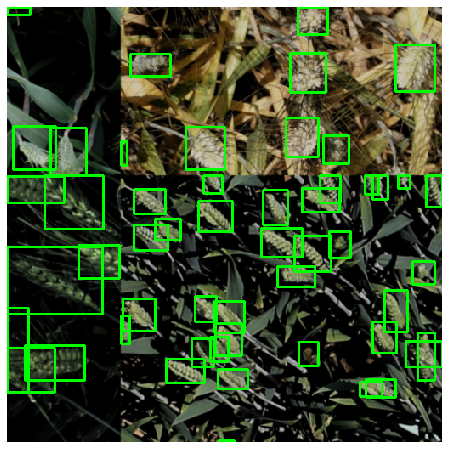

In [18]:
image, target, image_id = train_dataset[0]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

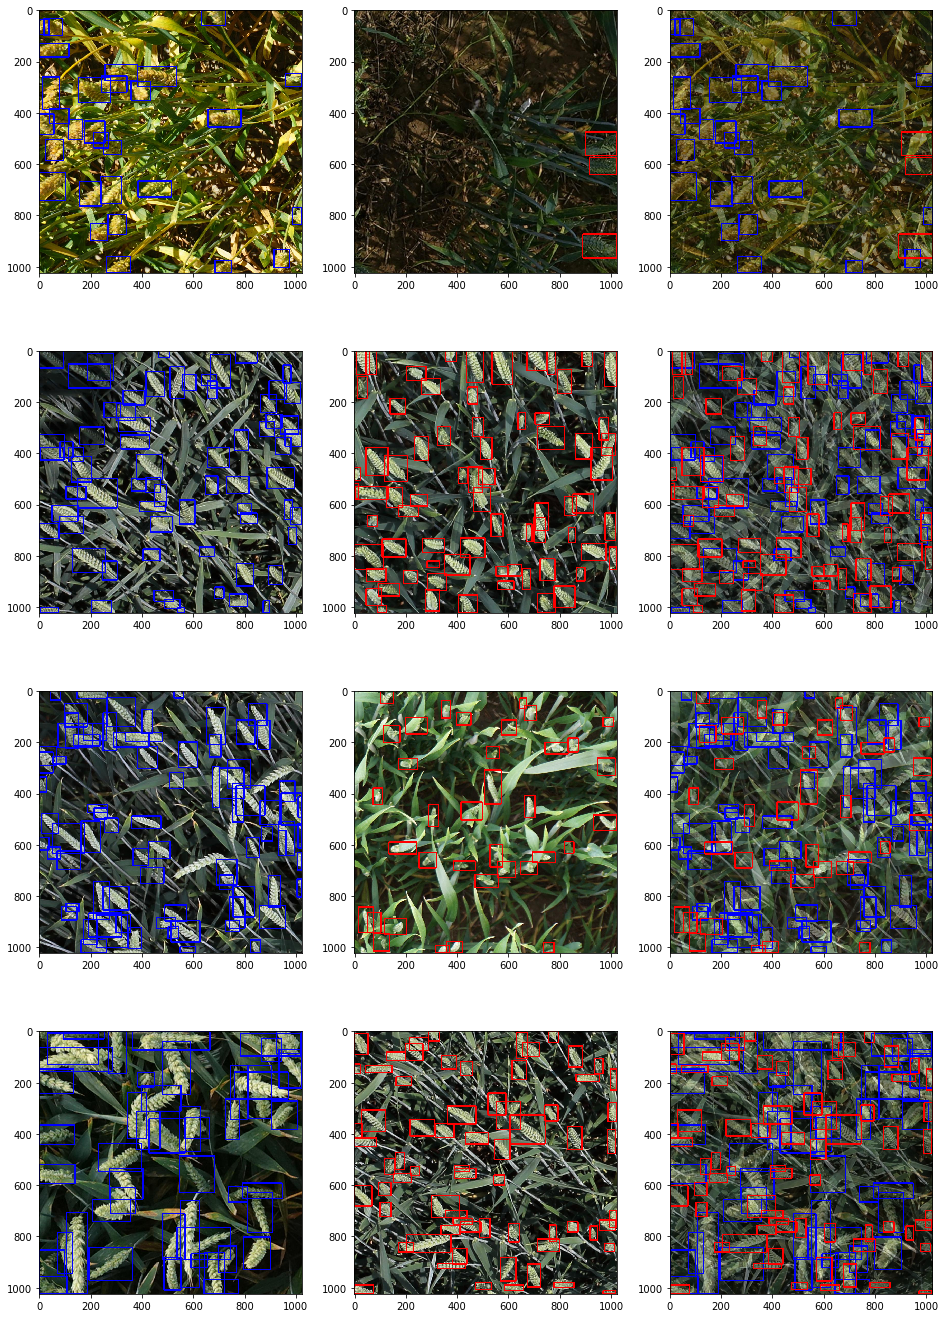

In [19]:
count = 4

fig, ax = plt.subplots(count, 3, figsize=(16, 6*count))

for i in range(count):
    image, boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    r_image, r_boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    mixup_image = (image+r_image)/2

    for box in boxes.astype(int):
        cv2.rectangle(image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        cv2.rectangle(mixup_image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        
    for box in r_boxes.astype(int):
        cv2.rectangle(r_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        cv2.rectangle(mixup_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        
    ax[i][0].imshow(image)
    ax[i][1].imshow(r_image)
    ax[i][2].imshow(mixup_image)

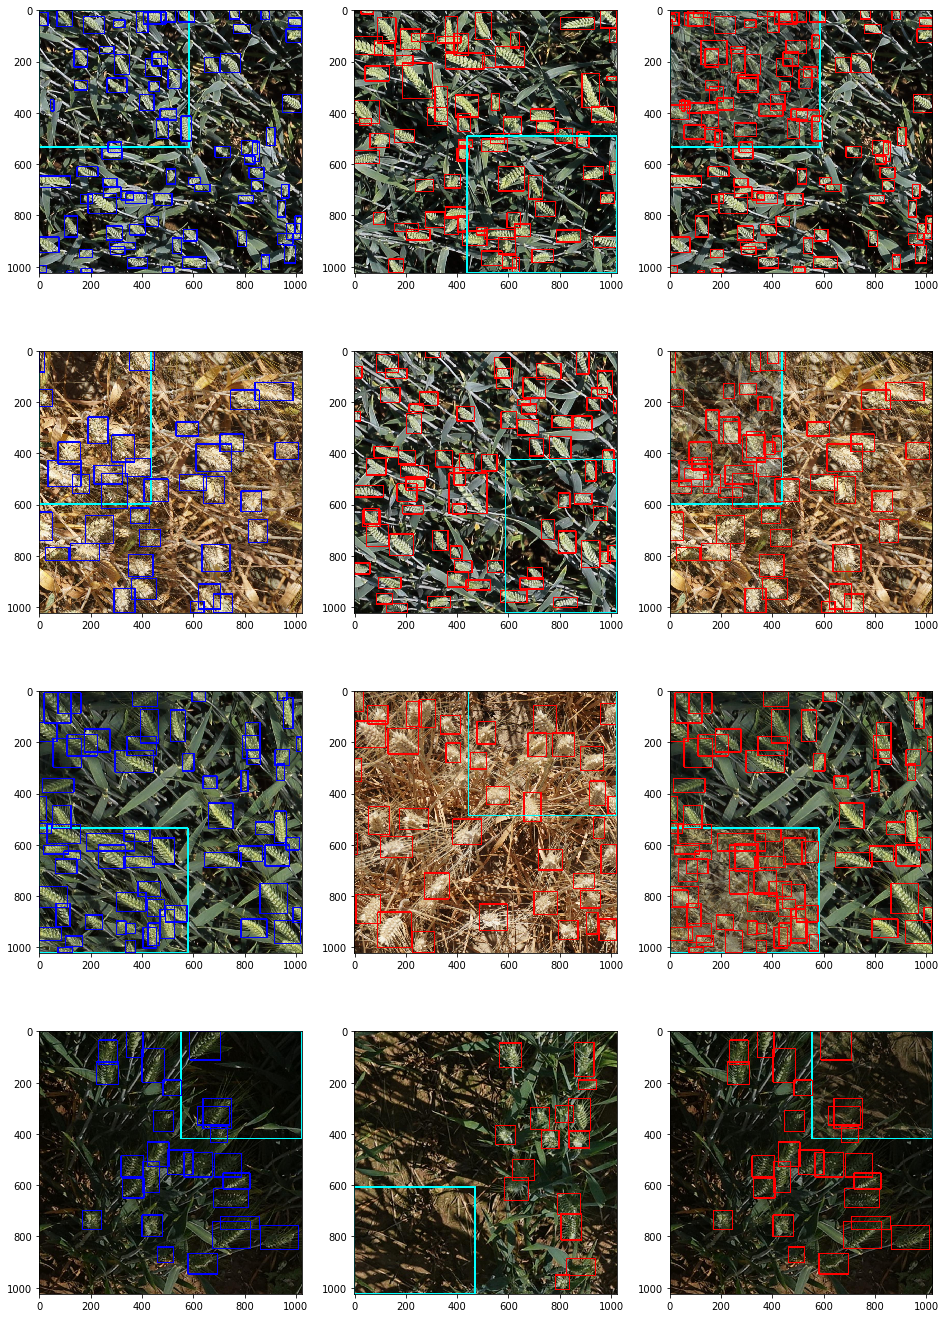

In [20]:
count = 4

fig, ax = plt.subplots(count, 3, figsize=(16, 6*count))

for i in range(count):
    image, boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    r_image, r_boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    
    for box in r_boxes.astype(int):
        cv2.rectangle(r_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)

    imsize = image.shape[0]
    w,h = imsize, imsize
    s = imsize // 2

    xc, yc = [int(random.uniform(imsize * 0.4, imsize * 0.6)) for _ in range(2)]
    direct = random.randint(0, 3)

    result_image = image.copy()
    result_boxes = []

    if direct == 0:
        x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
        x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
    elif direct == 1:  # top right
        x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
        x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
    elif direct == 2:  # bottom left
        x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
        x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
    elif direct == 3:  # bottom right
        x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
        x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

    padw = x1a - x1b
    padh = y1a - y1b

    r_boxes[:, 0] += padw
    r_boxes[:, 1] += padh
    r_boxes[:, 2] += padw
    r_boxes[:, 3] += padh

    result_boxes.append(r_boxes)

    result_image[y1a:y2a, x1a:x2a] = (result_image[y1a:y2a, x1a:x2a] + r_image[y1b:y2b, x1b:x2b]) / 2 
    
    cv2.rectangle(image,(x1a, y1a),(x2a,  y2a),(0, 1, 1), 5)
    cv2.rectangle(r_image,(x1b, y1b),(x2b,  y2b),(0, 1, 1), 5)
    cv2.rectangle(result_image,(x1a, y1a),(x2a,  y2a),(0, 1, 1), 5)
    
    result_boxes = np.concatenate(result_boxes, 0)
    np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
    result_boxes = result_boxes.astype(np.int32)
    result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
    
    for box in boxes.astype(int):
        cv2.rectangle(image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        #cv2.rectangle(result_image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        
    for box in np.concatenate([result_boxes,boxes]).astype(int):
        cv2.rectangle(result_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        
    ax[i][0].imshow(image)
    ax[i][1].imshow(r_image)
    ax[i][2].imshow(result_image)

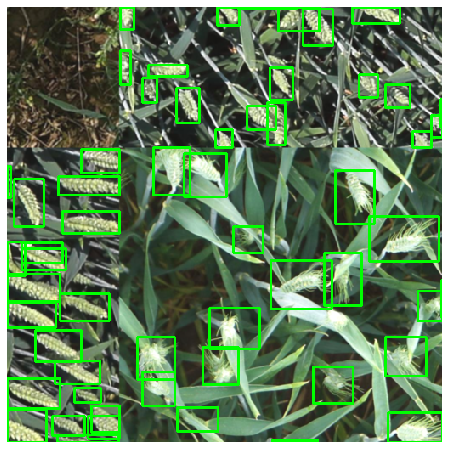

In [21]:
image, target, image_id = train_dataset[0]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

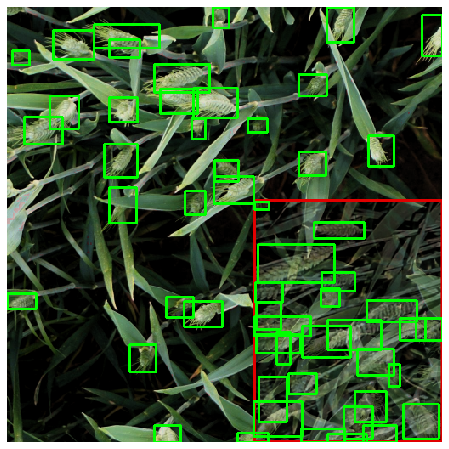

In [22]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

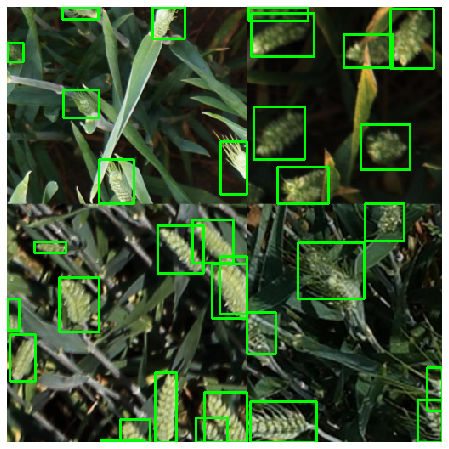

In [23]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

## Fitter

In [24]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [25]:
f'{1+2}'

'3'

In [26]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log_{self.config.ifold}.txt'
        #self.best_summary_loss = 10**5
        self.best_score = 0.
        self.model_file_best = f'{self.base_dir}/best-fold-{self.config.ifold}.pth'
        self.model_file_last = f'{self.base_dir}/last-fold-{self.config.ifold}.pth'

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=config.lr)
        #self.optimizer = torch.optim.SGD(self.model.parameters(), lr=config.lr, momentum=0.9, weight_decay=1e-4)
        lrs_config = config.lrs[config.lrs_name]
        self.scheduler = lrs_config['schedule_class'](self.optimizer, **lrs_config['schedule_params'])
        #self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def lrs_step(self, metrics):
        if self.config.lrs_name == 'plateau':
            self.scheduler.step(metrics)
        else:
            self.scheduler.step()

    def fit(self, train_loader, validation_loader):
        if self.load_best():
            if not isinstance(self.model.model, nn.DataParallel):
                self.model.model = nn.DataParallel(self.model.model)

            metrics = self.validation(validation_loader)
            self.best_score = metrics['best_score']
            print(metrics)
        else:
            if not isinstance(self.model.model, nn.DataParallel):
                self.model.model = nn.DataParallel(self.model.model)
        
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(self.model_file_last)

            t = time.time()
            metrics = self.validation(validation_loader)

            #self.log(f'[RESULT]: Val. Epoch: {self.epoch}, score: {metrics['best_score']}, \
            #    best: {self.best_score}, time: {(time.time() - t):.5f}')
            self.log('[VAL RESULT] Epoch {}, score: {}, best: {}, time: {:.5f}'.format(
                self.epoch, metrics['best_score'], self.best_score, (time.time() - t
            )))
            print(metrics)
            
            if metrics['best_score'] > self.best_score:
                self.best_score = metrics['best_score']
                self.model.eval()
                self.save(self.model_file_best)
                print('**saved**')
                
                #self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                #for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                #    os.remove(path)

            if self.config.validation_scheduler:
                #self.scheduler.step(metrics=summary_loss.avg)
                self.lrs_step(metrics=metrics['best_score'])

            self.epoch += 1

    def get_eval_det_model(self, model):
        config = get_efficientdet_config('tf_efficientdet_d5')
        config.num_classes = 1
        config.image_size = 512
        return DetBenchEval(model, config).cuda()
    
    def validation(self, val_loader):
        self.model.eval()
        eval_model = self.get_eval_det_model(self.model.model)
        metrics = eval_metrics(eval_model, val_loader, by_source=True)
        
        return metrics
        
    def validation_old(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                #self.scheduler.step()
                self.lrs_step(summary_loss.avg)

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        model_state = self.model.model.module.state_dict() if isinstance(self.model.model, nn.DataParallel) else self.model.model.state_dict()
        torch.save({
            'model_state_dict': model_state,
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_score': self.best_score,
            'epoch': self.epoch,
        }, path)

    def load_best(self):
        if os.path.exists(self.model_file_best):
            print(f'loading {self.model_file_best}...')
            self.load(self.model_file_best)
            return True
        else:
            print(f'{self.model_file_best} does not exist')
            return False

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        #self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        #self.best_score = checkpoint['best_score']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [27]:
#os.path.exists('a')

In [28]:
class TrainGlobalConfig:
    num_workers = 24
    batch_size = 30
    n_epochs = 300 # n_epochs = 40
    lr = 4e-4

    folder = 'ed5-mixup' #'effdet5-cutmix-augmix' #'ed5-mixup'
    ifold = 0

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss
    
    lrs_name = 'plateau' # plateau, cosine
    lrs = {
        'cosine': {
            'schedule_class': torch.optim.lr_scheduler.CosineAnnealingLR,
            'schedule_params': dict(
                T_max=12,
                eta_min=1e-6
            )
        },
        'plateau': {
            'schedule_class': torch.optim.lr_scheduler.ReduceLROnPlateau,
            'schedule_params': dict(
                mode='max',
                factor=0.5,
                patience=2,
                verbose=False, 
                threshold=0.0001,
                threshold_mode='abs',
                cooldown=0, 
                min_lr=2e-6,
                eps=1e-8
            )
        }
    }
    
    # --------------------
    #     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
    #     scheduler_params = dict(
    #         max_lr=0.001,
    #         epochs=n_epochs,
    #         steps_per_epoch=int(len(train_dataset) / batch_size),
    #         pct_start=0.1,
    #         anneal_strategy='cos', 
    #         final_div_factor=10**5
    #     )


In [29]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda')
    net.to(device)
    #net.cuda()
    #net.model = nn.DataParallel(net.model)
    
    train_dataset, validation_dataset = get_train_val_datasets(TrainGlobalConfig.ifold)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [30]:
#!pip install typing_extensions

In [31]:
def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=True)
    checkpoint = torch.load('../5folds/pretrained/efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    
    return DetBenchTrain(net, config)

net = get_net()

In [ ]:
run_training()

Fitter prepared. Device is cuda
./ed5-mixup/best-fold-0.pth does not exist

2020-05-28T18:52:49.270909
LR: 0.0004


### Thank you for reading my kernel!

So, I have prepared good training SOTA-model baseline for you, my friends! I have used n_epochs = 40 and have got best checkpoint single model that gives 0.7176 LB. You can see [here](https://www.kaggle.com/shonenkov/inference-efficientdet) inference kernel.

Just recently I have started publishing my works, if you like this format of notebooks I would like continue to make kernels.